In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import ndimage
from skimage.feature import peak_local_max
from sklearn.cluster import DBSCAN, AffinityPropagation, MeanShift
from matplotlib import cm
from skimage.segmentation import chan_vese

In [2]:
MIN = 0
MAX = 2 ** 16 - 1

In [3]:
# import all images per sequence, return images
def import_sequences():
    PATH = '../sequences/0'
    imgs = []
    for i in range(1, 5):
        imgs_path = []
        for image in glob(f'{PATH}{i}/*.tif'):
            img = cv2.imread(image, -1)
            imgs_path.append(cv2.normalize(img, dst=None, alpha=MIN, beta=MAX, norm_type=cv2.NORM_MINMAX))
        imgs.append(imgs_path)
    return imgs

In [4]:
imgs = import_sequences()

In [5]:
NROWS = imgs[0][0].shape[0]
NCOLS = imgs[0][0].shape[1]

In [6]:
# show an image inline
def show(img, s=True):
    plt.imshow(img, cmap='gray')
    if s:
        plt.show()

In [7]:
# segment original image using thresholding
def segment(original):
    img = np.zeros_like(original)
    cv2.threshold(original, dst=img, thresh=np.median(original)*1.2, maxval=MAX, type=cv2.THRESH_BINARY)
    struct_element = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
    img1 = np.zeros_like(original)
    cv2.morphologyEx(img, dst=img1, op=cv2.MORPH_OPEN, kernel=struct_element, borderValue=cv2.BORDER_REFLECT)
    img2 = np.zeros_like(original)
    cv2.threshold(img1, dst=img2, thresh=MAX-1, maxval=MAX, type=cv2.THRESH_BINARY)
    return img2

In [8]:
# get white points of an image, return dict of coord tuples
def points(img):
    pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == MAX:
                pts[(i,j)] = None
    return pts

In [51]:
# create an image from points
def create_img(pts):
    new = np.zeros((NROWS, NCOLS))
    for (i, j) in pts:
        new[i, j] = MAX
    return new.astype('uint16')

In [10]:
# flush all cells that touch the border of the image
def flush_border_cells(pts, img):
    to_check = []
    border_pts = {}
    border_img = np.zeros((NROWS, NCOLS))
    for pt in pts:
        if pt[0] == 0 or pt[1] == 0 or pt[0] == NROWS-1 or pt[1] == NCOLS-1:
            to_check.append(pt)
            border_pts[pt] = None
            border_img[pt[0], pt[1]] = MAX
    while len(to_check) > 0:
        b_pt = to_check.pop(0)
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (b_pt[0]+i, b_pt[1]+j) in pts and (b_pt[0]+i, b_pt[1]+j) not in border_pts:
                    to_check.append((b_pt[0]+i, b_pt[1]+j))
                    border_pts[(b_pt[0]+i, b_pt[1]+j)] = None
                    border_img[b_pt[0]+i, b_pt[1]+j] = MAX
    '''
    cnt = 0
    while cnt < 50000:
        if len(to_check) == 0:
            break
        if cnt == 49999:
            print(len(to_check))
        b_pt = to_check.pop(0)
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (b_pt[0]+i, b_pt[1]+j) in pts and (b_pt[0]+i, b_pt[1]+j) not in border_pts:
                    to_check.append((b_pt[0]+i, b_pt[1]+j))
                    border_pts[(b_pt[0]+i, b_pt[1]+j)] = None
                    border_img[b_pt[0]+i, b_pt[1]+j] = MAX
        cnt += 1
    '''
    new = img - border_img
    return points(new), new.astype('uint16')

In [11]:
# from points and labels create a coloured image
def colour_label_image(pts_labels, show=True, max=None):
    cmap = cm.get_cmap('hsv').copy()
    new_img = np.zeros((NROWS, NCOLS))
    cmap.set_bad(color='black')
    for (pt, label) in pts_labels.items():
        new_img[pt[0],pt[1]] = label
    if max == None:
        norm_new = plt.Normalize(new_img.min(), new_img.max())
    else:
        norm_new = plt.Normalize(new_img.min(), max)
    for i in range(NROWS):
        for j in range(NCOLS):
            if (i,j) not in pts_labels:
                new_img[i,j] = np.nan
    rgba_img = cmap(norm_new(new_img))
    if show:
        plt.imshow(rgba_img)
        plt.show()
    return rgba_img

In [12]:
# plot scatter of centroids over the colour labelled image
def plt_rgb_img_scatter(centroids, pts_labels):
    rgb_img = colour_label_image(pts_labels, False)
    plt.imshow(rgb_img)
    for (x, y) in centroids.keys():
        plt.scatter(y, x, c='white', marker='.')
    plt.show()

In [13]:
# check coords within image bounds
def check_coords(pt):
    if pt[0] < 0 or pt[0] > NROWS-1 or pt[1] < 0 or pt[1] > NCOLS-1:
        return False
    return True

In [14]:
# binary erosion of points with 3x3 filter
def erode(pts):
    eroded1_pts = {}
    for (x,y) in pts:
        if (x,y-1) in pts and (x, y+1) in pts:
            eroded1_pts[(x,y)] = pts[(x,y)]
    eroded2_pts = {}
    for (x,y) in eroded1_pts:
        if (x-1,y) in eroded1_pts and (x+1, y) in eroded1_pts:
            eroded2_pts[(x,y)] = eroded1_pts[(x,y)]
    return eroded2_pts

In [15]:
# binary dialtion of points with 3x3 filter
def dilate(pts):
    dilated1_pts = pts.copy()
    for (x,y) in pts:
        if (x,y-1) not in pts and check_coords((x,y-1)):
            dilated1_pts[(x, y-1)] = pts[(x,y)]
        if (x, y+1) not in pts and check_coords((x,y+1)):
            dilated1_pts[(x, y+1)] = pts[(x,y)]
    dilated2_pts = dilated1_pts.copy()
    for (x,y) in dilated1_pts:
        if (x-1,y) not in dilated1_pts and check_coords((x-1,y)):
            dilated2_pts[(x-1, y)] = dilated1_pts[(x,y)]
        if (x+1, y) not in dilated1_pts and check_coords((x+1,y)):  
            dilated2_pts[(x+1, y)] = dilated1_pts[(x,y)]
    return dilated2_pts

In [16]:
# get cell contours (outlines) from points
def contours(pts):
    dilated2_pts = dilate(pts)
    sub = {}
    for pt, label in dilated2_pts.items():
        if pt not in pts:
            sub[pt] = label
    return sub

In [17]:
# check that points are not colliding for rebuilding seperation
def no_collision(pt, label, existing_pts):
    for (i,j) in [(0, -1), (0, 1), (-1, 0), (1, 0)]:
        point = (pt[0]+i,pt[1]+j)
        if point in existing_pts and label != existing_pts[point]:
                return False
    '''
    for i in range(-1, 2):
        for j in range(-1, 2):
            point = (pt[0]+i,pt[1]+j)
            if point in existing_pts and label != existing_pts[point]:
                return False
    '''
    return True

In [18]:
# rebuild segmented image so no cells are touching
def rebuild(img, show=True, flush=True):
    if flush:
        pts, img = flush_border_cells(points(img), img)
    else:
        pts = points(img)
    distance = ndimage.distance_transform_edt(img)
    coords = peak_local_max(distance, footprint=np.ones((7,7)), labels = img, min_distance=12)
    coords = {tuple(c): i for i, c in enumerate(coords)}
    
    dilated2_pts = coords.copy()
    while 1:
        base = dilated2_pts.copy()
        dilated1_pts = base.copy()
        for pt, label in base.items():
            pt1 = (pt[0],pt[1]-1)
            if pt1 in dilated1_pts:
                pass
            elif no_collision(pt1, label, dilated1_pts) and pt1 in pts:
                dilated1_pts[pt1] = label
            
            pt2 = (pt[0], pt[1]+1)
            if pt2 in dilated1_pts:
                pass
            elif no_collision(pt2, label, dilated1_pts) and pt2 in pts:
                dilated1_pts[pt2] = label
       
        dilated2_pts = dilated1_pts.copy()
        for pt, label in dilated1_pts.items():
            pt1 = (pt[0]-1,pt[1])
            if pt1 in dilated2_pts:
                pass
            elif no_collision(pt1, label, dilated2_pts) and pt1 in pts:
                dilated2_pts[pt1] = label
            
            pt2 = (pt[0]+1, pt[1])
            if pt2 in dilated2_pts:
                pass
            elif no_collision(pt2, label, dilated2_pts) and pt2 in pts:
                dilated2_pts[pt2] = label
        if base == dilated2_pts:
            break
    if show:
        colour_label_image(dilated2_pts)
    return dilated2_pts 

In [19]:
# get centroids from points
def centroids(pts):
    labels = {}
    for (x,y), label in pts.items():
        if label not in labels:
            labels[label] = {'x': [x], 'y': [y]}
            continue
        labels[label]['x'].append(x)
        labels[label]['y'].append(y)
    centres = {}
    for label, data in labels.items():
        centres[int(sum(data['x'])/len(data['x'])), 
                int(sum(data['y'])/len(data['y']))] = label
    return centres

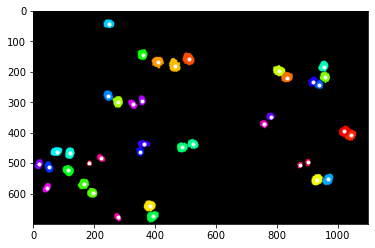

In [22]:
seg = segment(imgs[0][0])
pts = rebuild(seg, False)
centroid = centroids(pts)
plt_rgb_img_scatter(centroid, pts)

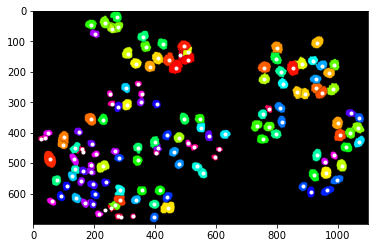

In [23]:
seg = segment(imgs[0][-1])
pts = rebuild(seg, False)
centroid = centroids(pts)
plt_rgb_img_scatter(centroid, pts)

## Cell Area

In [20]:
# find average size of cells in the image
def avg_cell_size(pts):
    labels = {}
    for label in pts.values():
        labels[label] = None
    return len(pts) / len(labels)

In [21]:
# count the number of cells in the image
def cell_count(pts):
    labels = {}
    for label in pts.values():
        labels[label] = None
    return len(labels)

## Chan_Vese Level Set Segmentation

In [22]:
# segment the image using Chan-Vese Level Set Method, then processing steps
def segment_CV(img):
    img_cv = chan_vese(img, mu=5, lambda1=1, lambda2=1, tol=1e-3,
                dt=3, init_level_set="checkerboard",
                extended_output=True)[0]
    vals = np.unique(img_cv, return_counts=True)[1]
    if vals[0] < vals[1]:
        img = np.logical_not(img_cv).astype('uint16') * MAX
    else:
        img = img_cv.astype('uint16') * MAX
    pts = points(img)
    mask = np.zeros((6,6))
    mask[1:-1,1:-1] = np.ones((4,4)) * MAX
    delete = {}
    for (i,j) in pts:
        if (i,j) in delete:
            continue
        if i-1 < 0 or i+5 > NROWS-1 or j-1 < 0 or j+5 > NCOLS-1:
            continue
        if np.array_equal(mask, img[i-1:i+5,j-1:j+5]):
            for m in range(4):
                for n in range(4):
                    delete[(i+m,j+n)] = None
    for pt in delete:
        del pts[pt]
    pts, _ = flush_border_cells(pts, create_img(pts))
    for i in range(2):
        pts = dilate(pts)
    for i in range(2):
        pts = erode(pts)
    img = create_img(pts).astype('uint16')
    imgb = np.zeros_like(img)
    imgb = cv2.GaussianBlur(img, dst=imgb, ksize=(0,0), sigmaX=4)
    imgb = cv2.threshold(imgb, dst=imgb, thresh=40000, maxval=MAX, type=cv2.THRESH_BINARY)[1]
    return imgb

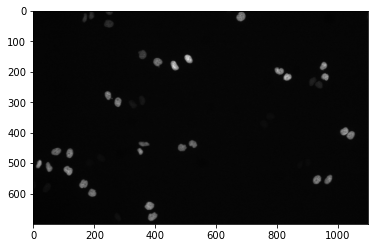

In [344]:
show(imgs[0][0])

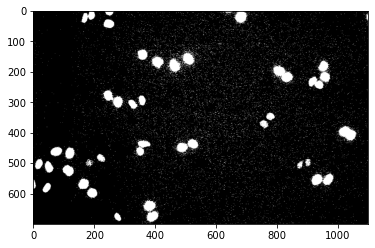

In [359]:
imgc = np.zeros_like(imgs[0][0])
imgc = cv2.threshold(imgs[0][0], dst=imgc, thresh=2200, maxval=MAX, type=cv2.THRESH_BINARY)[1]
show(imgc)

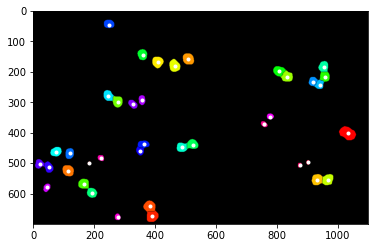

In [343]:
img = segment_CV(imgs[0][0])
pts = rebuild(img, False, False)
centroid = centroids(pts)
plt_rgb_img_scatter(centroid, pts)

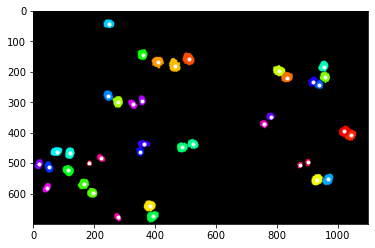

In [335]:
seg0 = segment(imgs[0][0])
pts0 = rebuild(seg0, False, True)
centroid0 = centroids(pts0)
plt_rgb_img_scatter(centroid0, pts0)

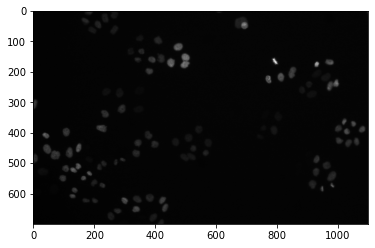

In [345]:
show(imgs[0][50])

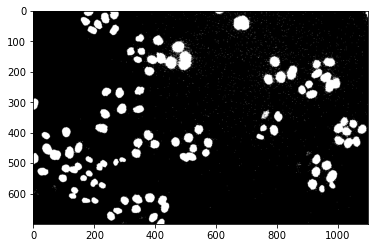

In [360]:
imgc = np.zeros_like(imgs[0][50])
imgc = cv2.threshold(imgs[0][50], dst=imgc, thresh=1700, maxval=MAX, type=cv2.THRESH_BINARY)[1]
show(imgc)

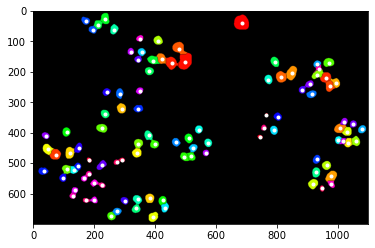

In [339]:
img = segment_CV(imgs[0][50])
pts = rebuild(img, False, False)
centroid = centroids(pts)
plt_rgb_img_scatter(centroid, pts)

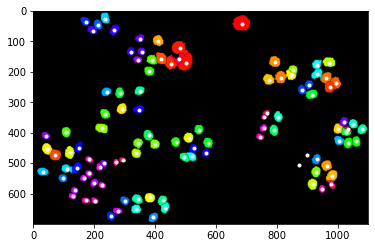

In [337]:
seg50 = segment(imgs[0][50])
pts50 = rebuild(seg50, False, True)
centroid50 = centroids(pts50)
plt_rgb_img_scatter(centroid50, pts50)

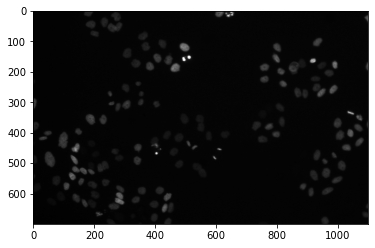

In [346]:
show(imgs[0][-1])

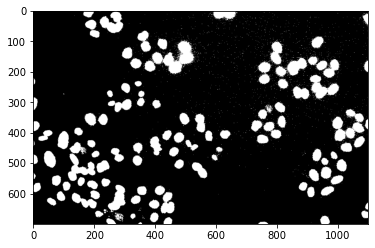

In [357]:
imgc = np.zeros_like(imgs[0][-1])
imgc = cv2.threshold(imgs[0][-1], dst=imgc, thresh=1700, maxval=MAX, type=cv2.THRESH_BINARY)[1]
show(imgc)

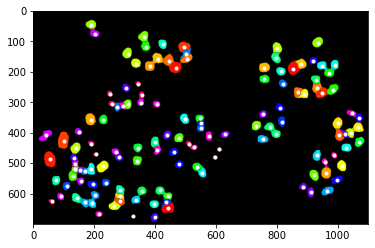

In [43]:
img = segment_CV(imgs[0][-1])
pts = rebuild(img, False, False)
centroid = centroids(pts)
plt_rgb_img_scatter(centroid, pts)

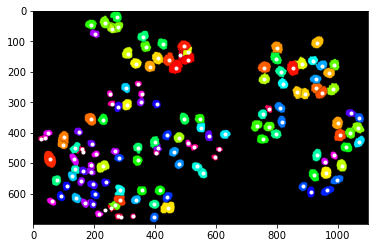

In [63]:
segL = segment(imgs[0][-1])
ptsL = rebuild(segL, False, True)
centroidL = centroids(ptsL)
plt_rgb_img_scatter(centroidL, ptsL)

In [64]:
len(centroidL)

143

In [66]:
avg_cell_size(ptsL)

775.916083916084

In [32]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [52]:
img = create_img(pts)

In [44]:
distance = ndi.distance_transform_edt(img)

In [75]:
coords = peak_local_max(distance, footprint=np.ones((5,5)), min_distance = 15, labels = img)

In [76]:
mask = np.zeros(distance.shape, dtype = bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
ws_labels = watershed(-distance, markers, mask = img)

C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


In [77]:
ws_pts = {}
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if ws_labels[i, j] == 0:
            continue
        ws_pts[(i, j)] = ws_labels[i, j]

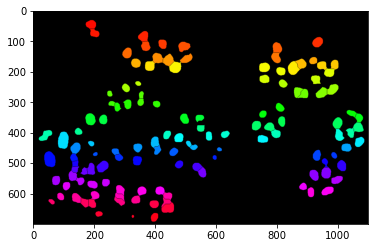

In [78]:
_ = colour_label_image(ws_pts)

In [79]:
ws_centroid = centroids(ws_pts)

In [80]:
len(ws_centroid)

127

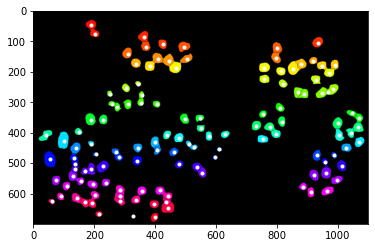

In [81]:
plt_rgb_img_scatter(ws_centroid, ws_pts)

In [123]:
# use watershed after Chan-Vese to get best results
def watershed_seg(img):
    distance = ndi.distance_transform_edt(img)
    coords = peak_local_max(distance, footprint=np.ones((5,5)), min_distance = 25, labels = img)
    mask = np.zeros(distance.shape, dtype = bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    ws_labels = watershed(-distance, markers, mask = img)
    ws_pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if ws_labels[i,j] == 0:
                continue
            ws_pts[(i,j)] = ws_labels[i,j]-1
    return ws_pts

In [105]:
img = segment_CV(imgs[0][3])

C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


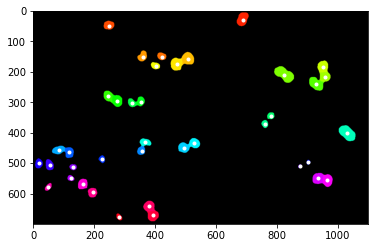

In [106]:
pts = watershed_seg(img)
centroid = centroids(pts)
plt_rgb_img_scatter(centroid, pts)

## Global labels, cell tracking

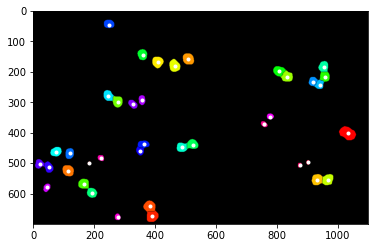

In [367]:
img0 = segment_CV(imgs[0][0])
pts0 = rebuild(img0, False, False)
centroid0 = centroids(pts0)
plt_rgb_img_scatter(centroid0, pts0)

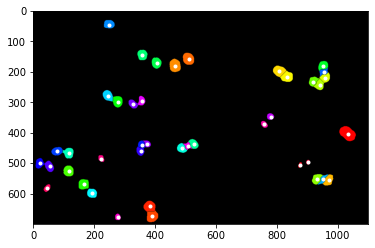

In [370]:
img1 = segment_CV(imgs[0][1])
pts1 = rebuild(img1, False, False)
centroid1 = centroids(pts1)
plt_rgb_img_scatter(centroid1, pts1)

In [442]:
dist_mat_0_1, rows_0_1, cols_0_1 = distance_matrix(centroid0, centroid1)

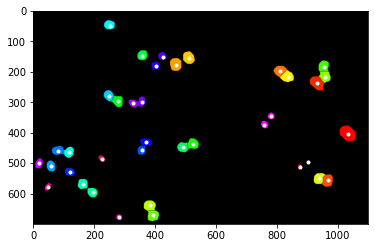

In [415]:
img2 = segment_CV(imgs[0][2])
pts2 = rebuild(img2, False, False)
centroid2 = centroids(pts2)
plt_rgb_img_scatter(centroid2, pts2)

In [443]:
dist_mat_1_2, rows_1_2, cols_1_2 = distance_matrix(centroid1, centroid2)

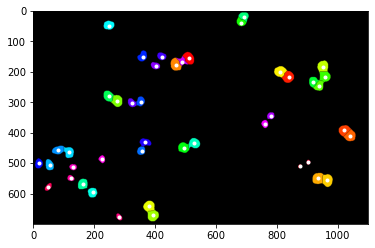

In [439]:
img3 = segment_CV(imgs[0][3])
pts3 = rebuild(img3, False, False)
centroid3 = centroids(pts3)
plt_rgb_img_scatter(centroid3, pts3)

In [444]:
dist_mat_2_3, rows_2_3, cols_2_3 = distance_matrix(centroid2, centroid3)

In [535]:
# get pairs of closest cells, or vanish/new cells
def pairwise(dist_mat, rows, cols):
    pairwise = {}
    not_new = {}
    for i, row in enumerate(dist_mat):
        if np.amin(row) > 10:
            pairwise[rows[i]] = 'vanish'
        else:
            pairwise[rows[i]] = cols[np.argmin(row)]
            not_new[np.argmin(row)] = None
    for j in range(dist_mat.shape[1]):
        if j not in not_new:
            pairwise[cols[j]] = 'new'
    return pairwise

In [495]:
pairs = pairwise(dist_mat_0_1, rows_0_1, cols_0_1)

In [497]:
pairwise_0_1 = {}
not_new = {}
for i, row in enumerate(dist_mat_0_1):
    if np.amin(row) > 10:
        pairwise_0_1[rows_0_1[i]] = 'vanish'
    else:
        pairwise_0_1[rows_0_1[i]] = cols_0_1[np.argmin(row)]
        not_new[np.argmin(row)] = None
for j in range(dist_mat_0_1.shape[1]):
    if j not in not_new:
        pairwise_0_1[cols_0_1[j]] = 'new'

In [503]:
clabels0 = {}
clabels1 = {}
for i, (pt1, pt2) in enumerate(pairs.items()):
    if type(pt2) == tuple:
        clabels0[pt1] = clabels1[pt2] = i
    elif pt2 == 'vanish':
        clabels0[pt1] = i
    else:
        clabels1[pt1] = i

In [505]:
global_pts0 = {}
for centroid in clabels0.keys():
    local_label = pts0[centroid]
    for pt, label in pts0.items():
        if label == local_label:
            global_pts0[pt] = clabels0[centroid]

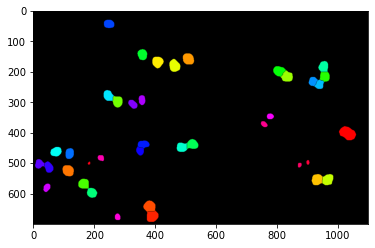

In [506]:
_ = colour_label_image(global_pts0)

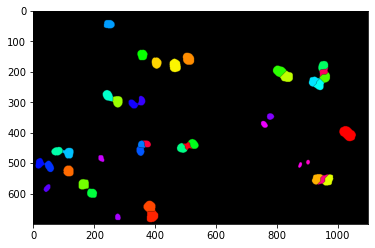

In [508]:
global_pts1 = {}
for centroid in clabels1.keys():
    local_label = pts1[centroid]
    for pt, label in pts1.items():
        if label == local_label:
            global_pts1[pt] = clabels1[centroid]
_ = colour_label_image(global_pts1)

In [509]:
pairs_01 = pairwise(dist_mat_0_1, rows_0_1, cols_0_1)

In [564]:
def global_labels(pairs, pts1, pts2, global_next_label):
    clabels1 = {}
    clabels2 = {}
    for (pt1, pt2) in pairs.items():
        if type(pt2) == tuple:
            clabels1[pt1] = clabels2[pt2] = pts1[pt1]
        elif pt2 == 'vanish':
            clabels1[pt1] = pts1[pt1]
        else:
            clabels2[pt1] = global_next_label
            global_next_label += 1
    global_labels1 = {}
    for centroid, global_label in clabels1.items():
        centroid_local_label = pts1[centroid]
        for pt, pt_local_label in pts1.items():
            if pt_local_label == centroid_local_label:
                global_labels1[pt] = global_label
    global_labels2 = {}
    for centroid, global_label in clabels2.items():
        centroid_local_label = pts2[centroid]
        for pt, pt_local_label in pts2.items():
            if pt_local_label == centroid_local_label:
                global_labels2[pt] = global_label
    return global_labels1, global_labels2, global_next_label

In [589]:
g0, g1, ncnt = global_labels(pairs_01, pts0, pts1, len(centroid0) + 1)

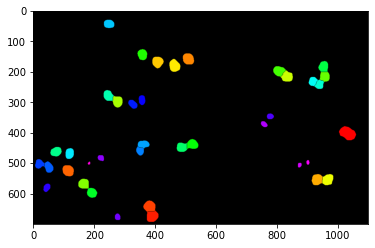

In [590]:
_ = colour_label_image(g0, max=ncnt)

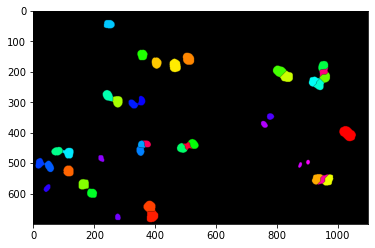

In [591]:
_ = colour_label_image(g1, max=ncnt)

In [592]:
def label_sequence(all_points):
    max_label = 0
    points_labels = {}
    for i in range(len(all_points)-1):
        centroids1 = centroids(all_points[i])
        centroids2 = centroids(all_points[i+1])
        dist_mat, rows, cols = distance_matrix(centroids1, centroids2)
        pairs = pairwise(dist_mat, rows, cols)
        g0, g1, max_label = global_labels(pairs, all_points[i], 
                                          all_points[i+1], max_label)
        colour_label_image(g0, max=max_label)
        points_labels[i] = g0
        points_labels[i+1] = g1
    return points_labels, max_label

## Cell Tracking

C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


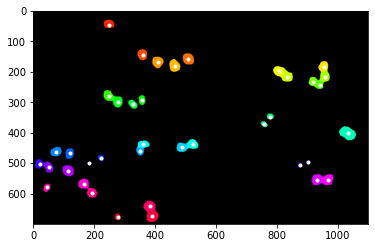

In [84]:
img0 = segment_CV(imgs[0][0])
pts0 = watershed_seg(img0)
centroid0 = centroids(pts0)
plt_rgb_img_scatter(centroid0, pts0)

C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


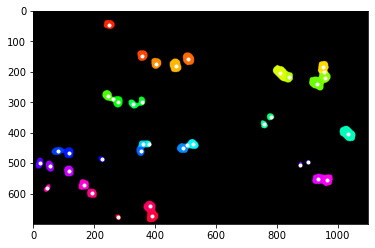

In [85]:
img1 = segment_CV(imgs[0][1])
pts1 = watershed_seg(img1)
centroid1 = centroids(pts1)
plt_rgb_img_scatter(centroid1, pts1)

C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


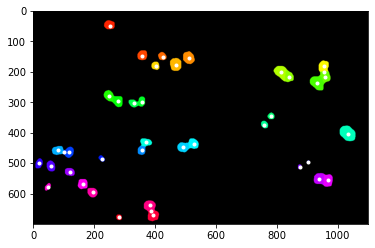

In [86]:
img2 = segment_CV(imgs[0][2])
pts2 = watershed_seg(img2)
centroid2 = centroids(pts2)
plt_rgb_img_scatter(centroid2, pts2)

C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


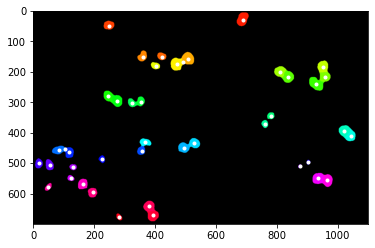

In [87]:
img3 = segment_CV(imgs[0][3])
pts3 = watershed_seg(img3)
centroid3 = centroids(pts3)
plt_rgb_img_scatter(centroid3, pts3)

In [23]:
# get distance matrix between sets of centroids
def distance_matrix(centroids1, centroids2):
    dist_mat = np.zeros((len(centroids1), len(centroids2)))
    rows = {}
    cols = {}
    for i, (x1,y1) in enumerate(centroids1):
        rows[i] = (x1,y1)
        for j, (x2,y2) in enumerate(centroids2):
            dist_mat[i,j] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    for j, pt in enumerate(centroids2):
        cols[j] = pt
    return dist_mat, rows, cols

### match based on distance: basic

In [24]:
def track_cells(imgs):
    pass

In [130]:
images = imgs[0][:25]
all_pts = {}
for i, img in enumerate(images):
    all_pts[i] = watershed_seg(segment_CV(img))

C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\s

In [131]:
centroid0 = centroids(all_pts[0])

In [132]:
tracking_labels = {0: centroid0.copy()}
tracking_labels[-1] = len(centroid0)

In [133]:
centroids1 = centroid0.copy()
for t, _ in enumerate(images[:-1]):
    centroids2 = centroids(all_pts[t+1])
    dist_mat, rows, cols = distance_matrix(centroids1, centroids2)
    tracking_labels[t+1] = {}
    exclude = 140
    new_cells = centroids2.copy()
    for i, row in enumerate(dist_mat):
        if np.amin(row) > exclude:
            continue
        tracking_labels[t+1][cols[np.argmin(row)]] = tracking_labels[t][rows[i]]
        if cols[np.argmin(row)] in new_cells:
            del new_cells[cols[np.argmin(row)]]
    for pt in new_cells.keys():
        tracking_labels[t+1][pt] = tracking_labels[-1]
        tracking_labels[-1] += 1
    centroids1 = centroids2.copy()

In [134]:
global_pts = {}
for t in range(len(images)):
    global_pts[t] = {}
    for pt, local_label in all_pts[t].items():
        for centroid, global_label in tracking_labels[t].items():
            if all_pts[t][centroid] == local_label:
                global_pts[t][pt] = global_label

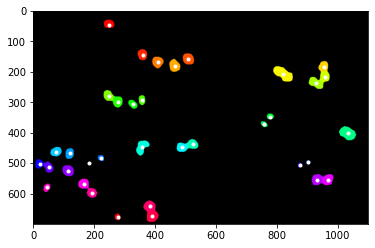

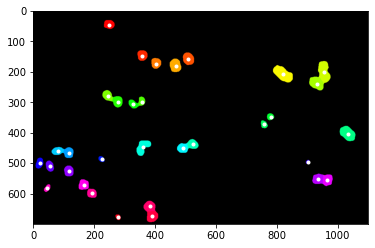

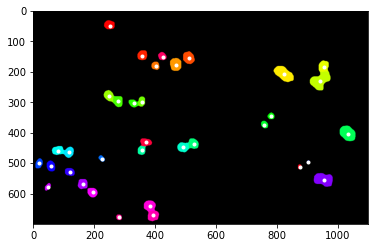

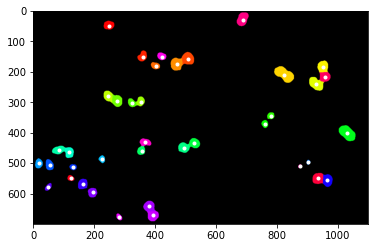

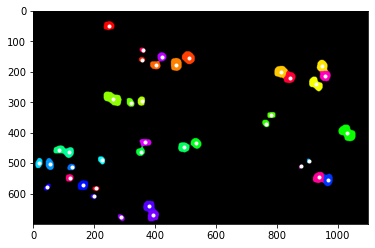

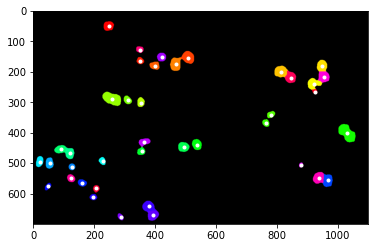

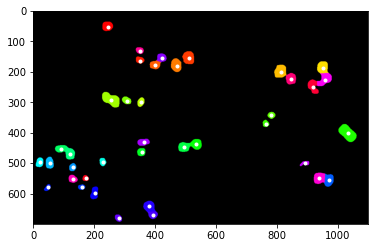

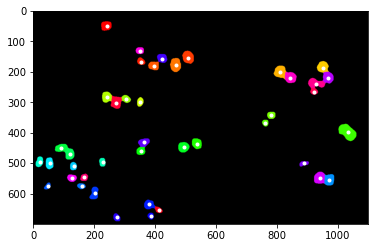

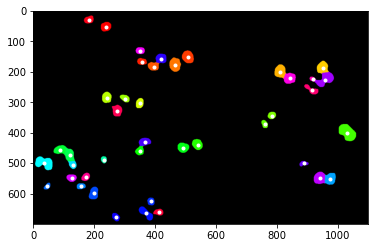

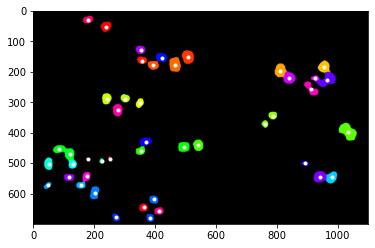

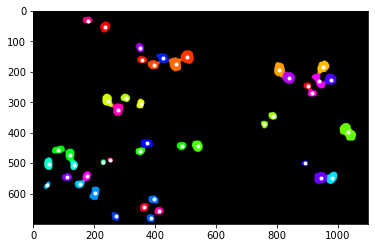

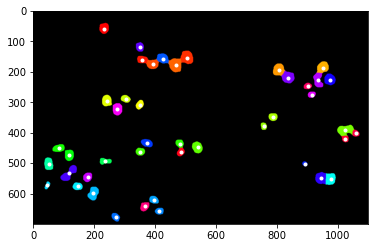

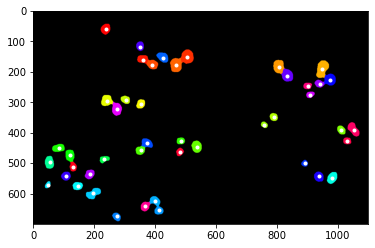

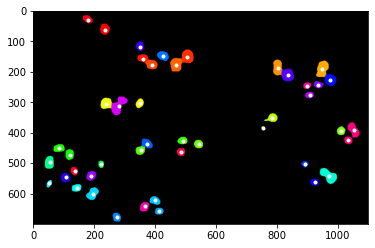

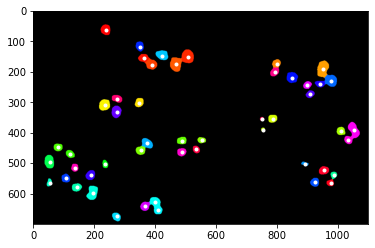

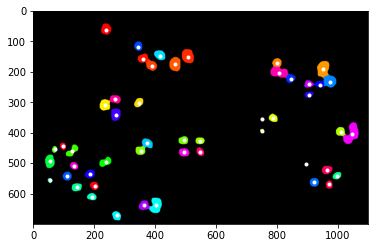

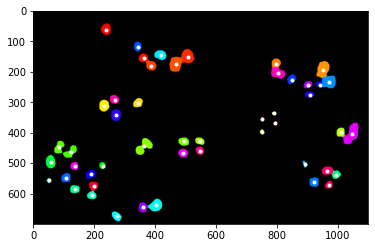

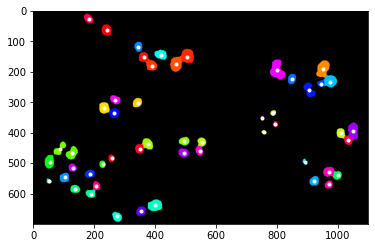

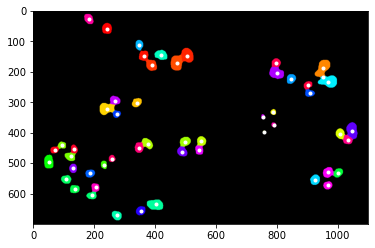

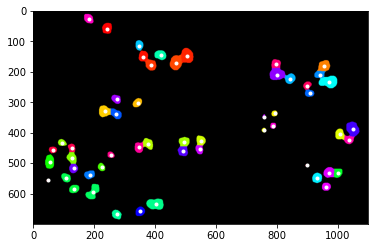

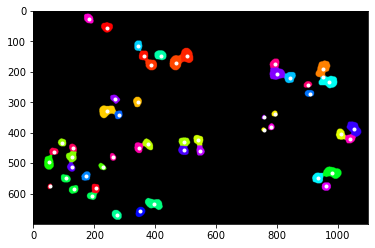

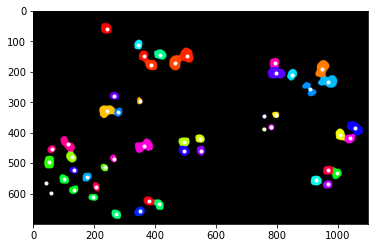

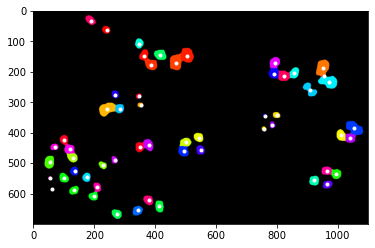

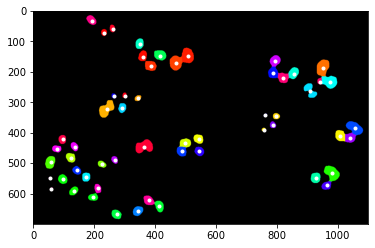

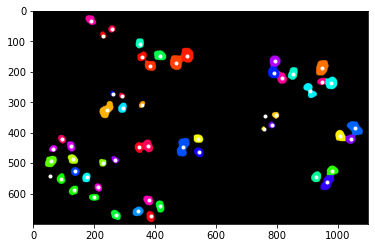

In [135]:
for pts in global_pts.values():
    #colour_label_image(pts, max=tracking_labels[-1]-1)
    plt_rgb_img_scatter(centroids(pts), pts)

In [652]:
dist_mat_0_0, rows_0_0, cols_0_0 = distance_matrix(centroid0, centroid0)
dist_mat_0_1, rows_0_1, cols_0_1 = distance_matrix(centroid0, centroid1)
dist_mat_1_1, rows_1_1, cols_1_1 = distance_matrix(centroid1, centroid1)

In [653]:
determined = {}

In [654]:
close_pairs_1_1 = {}
for i, row in enumerate(dist_mat_1_1):
    for j, dist in enumerate(row):
        if dist < 35 and dist != 0:
            close_pairs_1_1[rows_1_1[i]] = cols_1_1[j]

In [656]:
parent_centroid = {}
for pt1, pt2 in close_pairs_1_1.items():
    v1 = np.array([1/(pt2[0]-pt1[0]), -1/(pt2[1]-pt1[1])])
    for pt in centroid0.keys():
        v2 = np.array([pt1[0]-pt[0], pt1[1]-pt[1]])
        dist = np.dot(v1, v2) / np.linalg.norm(v1)
        if dist < 15 and pt1[0] <= pt[0] <= pt2[0] and pt1[1] <= pt[1] <= pt2[1]:
            mid0 = ((pt1[0]+pt2[0])/2,(pt1[1]+pt2[1])/2)
            num_close0 = 0
            for check0 in centroid0:
                if np.sqrt((mid[0]-check0[0]) ** 2 + (mid[1]-check0[1]) ** 2) < 50:
                    num_close0 += 1
            
            num_close1 = 0
            for check1 in centroid1:
                if np.sqrt((mid[0]-check0[0]) ** 2 + (mid[1]-check0[1]) ** 2) < 50:
                    num_close0 += 1
            parent_centroid[pt] = [pt1, pt2]